<a href="https://colab.research.google.com/github/NeoLeMarc/colab/blob/main/keras02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import os
import shutil
import string
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import preprocessing
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

print(tf.__version__)

!pip install kora -q
from kora import drive
drive.link_nbs()

import functions
functions.print_machine_info()

2.5.0
importing Jupyter notebook from /nbs/functions.ipynb
Sun May 30 07:00:16 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8     7W /  75W |      0MiB /  7611MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                             

# Sentiment analysis


In [2]:
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

dataset = tf.keras.utils.get_file("aclImdb_v1", url,
                                    untar=True, cache_dir='.',
                                    cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

print(os.listdir(dataset_dir))

train_dir = os.path.join(dataset_dir, 'train')
print(os.listdir(train_dir))

['test', 'train', 'imdbEr.txt', 'README', 'imdb.vocab']
['pos', 'unsupBow.feat', 'unsup', 'urls_neg.txt', 'urls_pos.txt', 'labeledBow.feat', 'neg', 'urls_unsup.txt']


In [3]:
sample_file = os.path.join(train_dir, 'pos/1181_9.txt')

functions.read_sample(sample_file)

Rachel Griffiths writes and directs this award winning short film. A heartwarming 
story about coping with grief and cherishing the memory of those we've loved and 
lost. Although, only 15 minutes long, Griffiths manages to capture so much emotion 
and truth onto film in the short space of time. Bud Tingwell gives a touching performance 
as Will, a widower struggling to cope with his wife's death. Will is confronted 
by the harsh reality of loneliness and helplessness as he proceeds to take care 
of Ruth's pet cow, Tulip. The film displays the grief and responsibility one feels 
for those they have loved and lost. Good cinematography, great direction, and superbly 
acted. It will bring tears to all those who have lost a loved one, and survived.


# Load dataset

In [5]:
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

# Create validation dataset by splitting up the train dataset 80:20

In [6]:
batch_size = 32
seed = 42

raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train',
    batch_size = batch_size,
    validation_split = 0.2,
    subset = 'training',
    seed = seed
)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


## Print a view examples


In [11]:
print("Label 0 corresponds to", raw_train_ds.class_names[0])
print("Label 1 corresponds to", raw_train_ds.class_names[1])

for text_batch, label_batch in raw_train_ds.take(1):
  for i in range(3):
    print("Review", text_batch.numpy()[i])
    print("Label", label_batch.numpy()[i])

Label 0 corresponds to neg
Label 1 corresponds to pos
Review b'Belmondo is a tough cop. He goes after a big-time drug dealer (played by Henry Silva, normally a great villain - see "Sharky\'s Machine"; but here he is clearly dubbed, and because of that he lacks his usual charisma). He goes to the scuzziest places of Paris and Marseilles, asks for some names, beats up some people, gets the names, goes to more scuzzy places, asks for more names, beats up more people, etc. The whole movie is punch after punch after punch. It seems that the people who made it had no other ambition than to create the French equivalent of "Dirty Harry". Belmondo, who was 50 here, does perform some good stunts at the beginning; apart from those, "Le Marginal" is a violent, episodic, trite, shallow and forgettable cop movie. (*1/2)'
Label 0
Review b'Wow. The only people reviewing this positively are the Carpenter apologists. I know a lot of those. The guys that\'ll watch John Carpenter squat on celluloid and pi

# Create validation and test dataset


In [12]:
raw_val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train',
    batch_size = batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed
)

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [13]:
raw_test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/test',
    batch_size = batch_size
)

Found 25000 files belonging to 2 classes.


# Prepare the dataset for training

In [27]:
import re
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')
  
max_features = 10000
sequence_length = 250

vectorize_layer = TextVectorization(
      standardize = custom_standardization,
      max_tokens = max_features,
      output_mode = 'int',
      output_sequence_length = sequence_length
      )

# Make a text-only dataaset (without labels), then call adapt
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

# retrieve a batch (of 32 reviews and labels) from the dataset
text_label, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized review", vectorize_text(first_review, first_label))

print("6992 ---> ",vectorize_layer.get_vocabulary()[6992])
print(" 248 ---> ",vectorize_layer.get_vocabulary()[248])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

Review tf.Tensor(b'Belmondo is a tough cop. He goes after a big-time drug dealer (played by Henry Silva, normally a great villain - see "Sharky\'s Machine"; but here he is clearly dubbed, and because of that he lacks his usual charisma). He goes to the scuzziest places of Paris and Marseilles, asks for some names, beats up some people, gets the names, goes to more scuzzy places, asks for more names, beats up more people, etc. The whole movie is punch after punch after punch. It seems that the people who made it had no other ambition than to create the French equivalent of "Dirty Harry". Belmondo, who was 50 here, does perform some good stunts at the beginning; apart from those, "Le Marginal" is a violent, episodic, trite, shallow and forgettable cop movie. (*1/2)', shape=(), dtype=string)
Label neg
Vectorized review (<tf.Tensor: shape=(1, 250), dtype=int64, numpy=
array([[   1,    7,    4, 1233, 1021,   27,  261,  101,    4,    1, 1525,
        6992,  248,   32, 1488,    1, 1659,    4,

# Final preprocessing

In [28]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

# Optimize for performance


In [29]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size = AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Create the model

In [30]:
embedding_dim = 16

model = tf.keras.Sequential([
                             layers.Embedding(max_features + 1, embedding_dim),
                             layers.Dropout(0.2),
                             layers.GlobalAveragePooling1D(),
                             layers.Dropout(0.2),
                             layers.Dense(1)
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          160016    
_________________________________________________________________
dropout_2 (Dropout)          (None, None, 16)          0         
_________________________________________________________________
global_average_pooling1d_1 ( (None, 16)                0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 160,033
Trainable params: 160,033
Non-trainable params: 0
_________________________________________________________________


# Compile the model

In [31]:
model.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

# Train the model

In [32]:
epochs = 10
history = model.fit(
    train_ds,
    validation_data = val_ds,
    epochs=epochs
)

Epoch 1/10
625/625 [==============================] - 9s 13ms/step - loss: 0.6634 - binary_accuracy: 0.6927 - val_loss: 0.6132 - val_binary_accuracy: 0.7734
Epoch 2/10
625/625 [==============================] - 3s 5ms/step - loss: 0.5465 - binary_accuracy: 0.8007 - val_loss: 0.4965 - val_binary_accuracy: 0.8230
Epoch 3/10
625/625 [==============================] - 3s 5ms/step - loss: 0.4429 - binary_accuracy: 0.8461 - val_loss: 0.4191 - val_binary_accuracy: 0.8476
Epoch 4/10
625/625 [==============================] - 3s 5ms/step - loss: 0.3773 - binary_accuracy: 0.8666 - val_loss: 0.3734 - val_binary_accuracy: 0.8590
Epoch 5/10
625/625 [==============================] - 3s 5ms/step - loss: 0.3350 - binary_accuracy: 0.8788 - val_loss: 0.3447 - val_binary_accuracy: 0.8668
Epoch 6/10
625/625 [==============================] - 3s 5ms/step - loss: 0.3036 - binary_accuracy: 0.8908 - val_loss: 0.3255 - val_binary_accuracy: 0.8728
Epoch 7/10
625/625 [==============================] - 3s 5ms/st

# Evaluate the model

In [33]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

782/782 [==============================] - 7s 8ms/step - loss: 0.3097 - binary_accuracy: 0.8740
Loss:  0.30971983075141907
Accuracy:  0.873960018157959


# Plot

In [34]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

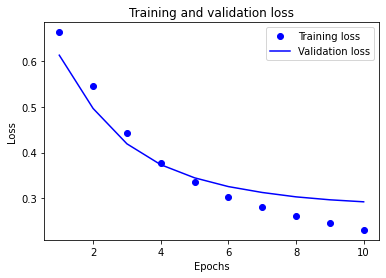

In [36]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for blue dot
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title("Training and validation loss")
plt.xlabel('Epochs')
plt.ylabel("Loss")
plt.legend()

plt.show()

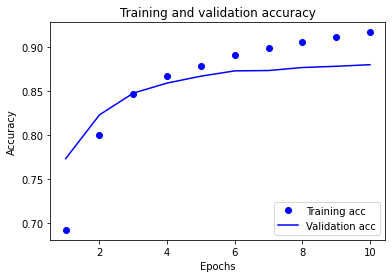

In [38]:
plt.plot(epochs, acc, 'bo', label = 'Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

# Export model

In [40]:
export_model = tf.keras.Sequential([
                                    vectorize_layer,
                                    model,
                                    layers.Activation('sigmoid')
])

export_model.compile(
    loss = losses.BinaryCrossentropy(from_logits=False), optimizer='adam', metrics=['accuracy']
)

# Test it with 'raw_test_ds' which yields raw strings
loss, accuacy = export_model.evaluate(raw_test_ds)
print(accuracy)

782/782 [==============================] - 9s 11ms/step - loss: 0.3097 - accuracy: 0.8740
0.873960018157959


# Inference on new data


In [41]:
examples = [
            "The movie was great!",
            "The moview was okay.",
            "The movie was terrible..."
]

export_model.predict(examples)

array([[0.6069582 ],
       [0.4279843 ],
       [0.34686738]], dtype=float32)